In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import cv2

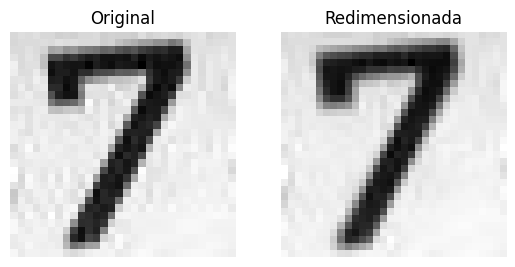

(32, 32, 1)
Primer pixel
Original:  208
Normalitzat:  0.8156862745098039


In [3]:
# Ruta de la imagen
image_path = '../char-test/7-test.jpg'

# Cargar la imagen en escala de grises
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Redimensionar la imagen al tamaño esperado por el modelo
resized_image = cv2.resize(image, (32, 32))  # Cambiar (32, 32) si el modelo espera otro tamaño

# Mostrar la imagen original y la redimensionada
plt.subplot(1, 2, 1)
plt.title('Original')
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.title('Redimensionada')
plt.imshow(resized_image, cmap='gray')
plt.axis('off')
plt.show()

# Normalizar la imagen
normalized_image = resized_image / 255.0

# Expandir dimensiones para que coincida con el formato esperado por el modelo
input_image = np.expand_dims(normalized_image, axis=-1)  # Añadir canal
#input_image = np.expand_dims(input_image, axis=0)  # Añadir batch

print(input_image.shape)  # Verificar la forma de la imagen procesada
print('Primer pixel')
print('Original: ', image[0][0]) # Primer pixerl
print('Normalitzat: ', input_image[0][0][0]) 

In [2]:
import string
# Ruta del dataset
dataset_path = 'dades'

# Crear un mapeo de caracteres válidos (0-9 y A-Z)
valid_characters = list(string.digits + string.ascii_uppercase)  # ['0', '1', ..., '9', 'A', ..., 'Z']
char_to_index = {char: idx for idx, char in enumerate(valid_characters)}  # {'0': 0, ..., 'A': 10, ..., 'Z': 35}


# Inicializar listas para imágenes y etiquetas
images = []
labels = []

# Recorrer las subcarpetas
for label in os.listdir(dataset_path):
    label_path = os.path.join(dataset_path, label)
    if os.path.isdir(label_path):  # Verificar si es una carpeta
        for image_file in os.listdir(label_path):
            image_path = os.path.join(label_path, image_file)
            # Cargar la imagen en escala de grises
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            if image.shape[0] != 32 or image.shape[1] != 32:
                # Redimensionar la imagen al tamaño esperado por el modelo
                image = cv2.resize(image, (32, 32))
            # Normalizar la imagen
            normalized_image = image / 255.0
            # Expandir dimensiones para que coincida con el formato esperado por el modelo
            input_image = np.expand_dims(normalized_image, axis=-1)
            # Agregar la imagen y la etiqueta a las listas
            images.append(input_image)
            # Convertir etiquetas alfanuméricas a enteros únicos
            labels.append(char_to_index[label])  # Usar el índice mapeado como etiqueta

# Convertir las listas a arrays de NumPy
images = np.array(images)
labels = np.array(labels)

# Total de imágenes y etiquetas
print(f"Total de imágenes: {len(images)}")
print(f"Total de etiquetas: {len(labels)}")

# Dividir el dataset en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# Convertir las etiquetas a one-hot encoding
y_train = to_categorical(y_train, num_classes=36)
y_test = to_categorical(y_test, num_classes=36)

print(f"Forma de X_train: {X_train.shape}")
print(f"Forma de y_train: {y_train.shape}")
print(f"Forma de X_test: {X_test.shape}")
print(f"Forma de y_test: {y_test.shape}")

Total de imágenes: 3600
Total de etiquetas: 3600
Forma de X_train: (2880, 32, 32, 1)
Forma de y_train: (2880, 36)
Forma de X_test: (720, 32, 32, 1)
Forma de y_test: (720, 36)


In [6]:
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 1), padding='same'))
model.add(layers.MaxPooling2D((2, 2), padding='same'))
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2), padding='same'))

model.add(layers.Flatten())
model.add(layers.Dense(1000, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(500, activation='relu'))
model.add(layers.Dropout(0.3)) 
model.add(layers.Dense(36, activation='softmax'))

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1000)           │     4,097,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 500)            │       500,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 36)             │        18,036 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,634,352 (17.68 MB)

 Trainable params: 4,634,352 (17.68 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Configurar aumentación de datos
datagen = ImageDataGenerator(
    rotation_range=10,       # Rotar hasta 10 grados
    width_shift_range=0.1,   # Desplazar horizontalmente hasta un 10%
    height_shift_range=0.1,  # Desplazar verticalmente hasta un 10%
    zoom_range=0.1,          # Hacer zoom hasta un 10%
    shear_range=0.1,         # Aplicar cizalladura
    fill_mode='nearest'      # Rellenar píxeles vacíos
)

# Ajustar el generador a los datos de entrenamiento
datagen.fit(X_train)

In [7]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    #datagen.flow(X_train, y_train, batch_size=32),
    X_train, y_train,
    epochs=10,  # Número de épocas (puedes ajustarlo según sea necesario)
    batch_size=80,  # Tamaño del batch (puedes ajustarlo según sea necesario)
    validation_data=(X_test, y_test),  # Datos de validación
    callbacks=[early_stopping]  # Añadir EarlyStopping como callback
)

Epoch 1/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step - accuracy: 0.0993 - loss: 3.3840 - val_accuracy: 0.7375 - val_loss: 0.9745
Epoch 2/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 0.7719 - loss: 0.7611 - val_accuracy: 0.9708 - val_loss: 0.0960
Epoch 3/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - accuracy: 0.9509 - loss: 0.1607 - val_accuracy: 0.9875 - val_loss: 0.0336
Epoch 4/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 0.9841 - loss: 0.0560 - val_accuracy: 0.9972 - val_loss: 0.0165
Epoch 5/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - accuracy: 0.9888 - loss: 0.0353 - val_accuracy: 0.9944 - val_loss: 0.0132
Epoch 6/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 0.9919 - loss: 0.0243 - val_accuracy: 0.9972 - val_loss: 0.0080
Epoch 7/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - accuracy: 0.9961 - loss: 0.0128 - val_accuracy: 0.9958 - val_loss: 0.0097
Epoch 8/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - accuracy: 0.9952 - loss: 0.0161 - val_accuracy: 0.9958 - v

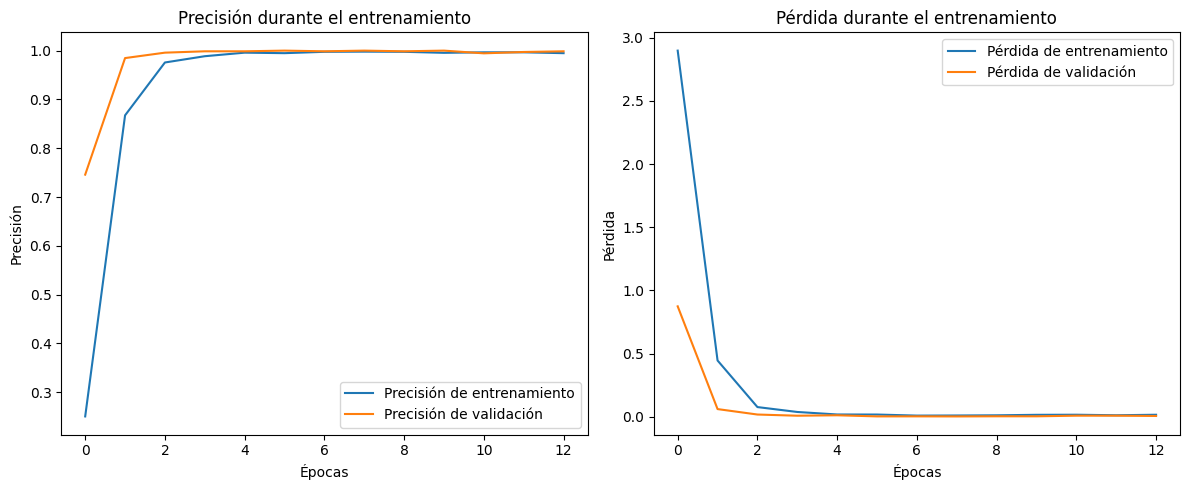

In [8]:
# Crear subplots para precisión y pérdida
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Graficar la precisión del entrenamiento y validación
axes[0].plot(history.history['accuracy'], label='Precisión de entrenamiento')
axes[0].plot(history.history['val_accuracy'], label='Precisión de validación')
axes[0].set_xlabel('Épocas')
axes[0].set_ylabel('Precisión')
axes[0].legend()
axes[0].set_title('Precisión durante el entrenamiento')

# Graficar la pérdida del entrenamiento y validación
axes[1].plot(history.history['loss'], label='Pérdida de entrenamiento')
axes[1].plot(history.history['val_loss'], label='Pérdida de validación')
axes[1].set_xlabel('Épocas')
axes[1].set_ylabel('Pérdida')
axes[1].legend()
axes[1].set_title('Pérdida durante el entrenamiento')

# Mostrar los gráficos
plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


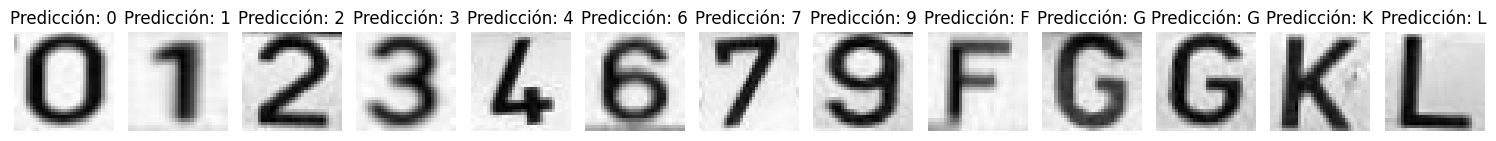

In [8]:
# Definir la ruta de la carpeta de imágenes de prueba
test_folder_path = '../char-test'

# Obtener la lista de imágenes de prueba
test_images = [os.path.join(test_folder_path, f) for f in os.listdir(test_folder_path) if f.endswith('.jpg')]

# Crear un subplot para mostrar todas las imágenes de prueba y sus predicciones
fig, axes = plt.subplots(1, len(test_images), figsize=(15, 5))

# Iterar sobre las imágenes de prueba
for i, test_image_path in enumerate(test_images):
    # Cargar la imagen en escala de grises
    test_image = cv2.imread(test_image_path, cv2.IMREAD_GRAYSCALE)
    
    # Redimensionar la imagen al tamaño esperado por el modelo
    resized_test_image = cv2.resize(test_image, (32, 32))
    
    # Normalizar la imagen
    normalized_test_image = resized_test_image / 255.0
    
    # Expandir dimensiones para que coincida con el formato esperado por el modelo
    test_input = np.expand_dims(normalized_test_image, axis=(0, -1))
    
    # Realizar la predicción
    prediction = model.predict(test_input)
    
    # Obtener el índice de la clase con mayor probabilidad
    predicted_class = np.argmax(prediction)
    
    # Convertir el índice a su carácter correspondiente
    predicted_character = valid_characters[predicted_class]
    
    # Mostrar la imagen y la predicción en el subplot correspondiente
    axes[i].imshow(resized_test_image, cmap='gray')
    axes[i].set_title(f'Predicción: {predicted_character}')
    axes[i].axis('off')

# Ajustar el diseño del subplot
plt.tight_layout()
plt.show()

In [11]:
model.save('caracter_model.keras')